In [8]:
#!pip install statannotations

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
from statannotations.Annotator import Annotator #https://github.com/trevismd/statannotations

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_1samp  

# if getting OptionError: "No such keys(s): 'mode.use_inf_as_null'"
# !pip install --upgrade seaborn pandas

import matplotlib as mpl
import os
from glob import glob

from _load_data import * # Getting our specific labels, formatting, and data

# Getting some free samples
# display(results_df.sample(3))

print(gens)

# Don't change any code below, it may break (probably will) --------------------

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 200]


In [16]:
# Filter the DataFrame
filtered_df = results_df[results_df['dataset'] == 'Airfoil']

# Group by 'model' and find the index of the minimum 'size' for each 'model'
min_indices = filtered_df.groupby('model')['test_mse'].idxmin()

# Select the corresponding rows from the DataFrame
smallest_sizes_df = filtered_df.loc[min_indices]

expressions = smallest_sizes_df[['model', 'representation', 'test_mse', 'size']]
expressions

,model,representation,test_mse,size
57,Bottom Up,"add(multiply(subtract(-0.005357532633562378, add(multiply(-0.022227266781002664, log1p(x_4)), multiply(0.0006487102060263808, log(x_4)))), maximum(x_0, add(cdiv(16340.92649418457, multiply(x_0, x_4)), multiply(-22073.75314336623, arctan(x_2))))), subtract(135.8739611704705, multiply(subtract(multiply(minimum(1901.390947084342, x_0), x_2), -166.93885208761185), cdiv(sqrtabs(x_4), cdiv(x_3, -8.759460120799702)))))",10.354647,41
61,Top Down,"add(cdiv(subtract(subtract(cdiv(23.65659357007414, x_4), multiply(3.549157637287803e-08, square(x_0))), multiply(subtract(20.241689848562295, multiply(1.5358495507216068, x_3)), cdiv(multiply(x_2, x_1), maximum(x_1, 12.306169749565335)))), log(multiply(subtract(cdiv(798.5330697787285, x_1), multiply(-0.9915328872053184, x_0)), cdiv(log1p(x_4), maximum(x_1, 4.549666461798888))))), cdiv(subtract(144.95449066874673, multiply(0.6047666889547977, maximum(x_1, x_4))), cos(subtract(cdiv(subtract(104.38178605574879, x_2), x_4), x_2))))",7.267089,55
11,Without simplify,"cdiv(subtract(subtract(cdiv(subtract(multiply(-11417801.70498638, x_2), 731211.5412300316), subtract(multiply(x_3, x_0), multiply(-954522.5222022196, x_2))), add(subtract(log(x_0), 158.0004350314493), subtract(log1p(x_0), multiply(-13.884746485705758, x_2)))), multiply(add(subtract(log(x_0), 13.970056781696472), subtract(log1p(x_0), multiply(-2.7867907092534505, x_2))), log(multiply(expm1(x_4), x_0)))), add(expm1(expm1(expm1(sqrtabs(x_4)))), x_4))",11.787467,51


In [2]:
from sympy import *
import re

func_dict = {
    'multiply': '*',
    'subtract': '-',
    'add3': '+',
    'add4': '+',
    'mul3': '*',
    'mul4': '*',
    'cdiv': '/',
    'add': '+'
}

func_arity = {
    'multiply': 2,
    'subtract': 2,
    'add3': 3,
    'add4': 4,
    'mul3': 3,
    'mul4': 4,
    'cdiv': 2,
    'add': 2,
    'maximum' : 2,
    'minimum' : 2,
    'max' : 2,
    'min' : 2,
    'sin' : 1,
    'cos' : 1,
    'tan' : 1,
    'arcsin' : 1,
    'arccos' : 1,
    'arctan' : 1,
    'sqrtabs' : 1,
    'sqrt' : 1,
    'abs' : 1,
    'log1p'   : 1,
    'log'     : 1,
    'exp'     : 1,
    'expm1'   : 1,
    'square'  : 1,
    'absolute' : 1
}

def pretify_expr(string):
    # Breaking down into a list of symbols. handliilng sqrtabs and max/minimum
    ind = string.replace('sqrtabs','sqrt').replace('imum','') \
                .replace(' ','').replace(')','').replace('(',',').split(',')

    new_string = ""
    stack = []
    for node in ind:
        stack.append((node, []))
        while len(stack[-1][1]) == func_arity.get(stack[-1][0], 0):

            prim, args = stack.pop()
            new_string = prim
            if prim in func_dict.keys():
                new_string = '(' + func_dict[prim].join(args) + ')'
            elif not prim.startswith('x_'):
                try:
                    float(prim)
                except:
                    new_string = prim + '(' + args[0] + ')'
                
            if len(stack) == 0:
                break

            stack[-1][1].append(new_string)

    return new_string

def count_float_occurrences(s):
   pattern = r'\d+\.\d+' # Matches sequences of digits followed by a dot and more digits
   matches = re.findall(pattern, s)
   return len(matches)

def count_occurrences(s, sub):
   res = 0
   for i in range(len(s)):
       if s[i:i+len(sub)] == sub:
           res += 1
   return res

funcs = [
    '-', '+', '+', '/', 'maximum', 'minimum', 'max', 'min', 'sin', 'cos', 'tan', 
    'arcsin', 'arccos', 'arctan', 'sqrtabs', 'expm1',
    'sqrt', 'abs', 'log1p', 'log', 'exp', 'square', 'absolute']

In [3]:
new_columns = []

for i, col in results_df.iterrows():
    sympy_compatible = str(pretify_expr(col['representation']))
    try:
        sympy_simplified = str(simplify(sympy_compatible))
    except Exception as e:
        print(e)
        continue
    # stats: number of functions, constants, variables, and total number ofnodes
    n_features_before  = count_occurrences(sympy_compatible, "x_")
    n_constants_before = count_float_occurrences(sympy_compatible)
    n_functions_before = sum([count_occurrences(sympy_compatible, f)
                              for f in funcs])

    n_features_after  = count_occurrences(sympy_simplified, "x_")
    n_constants_after = count_float_occurrences(sympy_simplified)
    n_functions_after = sum([count_occurrences(sympy_simplified, f)
                             for f in funcs])

    new_columns.append([
        n_features_before-n_features_after,
        n_constants_before-n_constants_after,
        n_functions_before-n_functions_after,
        (n_features_before+n_constants_before+n_functions_before)-\
        (n_features_after+n_constants_after+n_functions_after),
    ])

deltas_df = pd.DataFrame(new_columns, columns=['features simplified',
                                               'constants simplified',
                                               'functions simplified',
                                               'nodes simplified'])

results_df = pd.concat([results_df, deltas_df], axis=1 )
results_df.sample(3)

,model,dataset,RunID,random_state,time,date,train_r2,test_r2,train_mse,test_mse,representation,size,complexity,depth,features simplified,constants simplified,functions simplified,nodes simplified
254,Top Down,Energy Cooling,0,18313,2318.482489,01-27-2024 14:20:48,0.906700,0.891771,7.699266,8.784196,"subtract(multiply(subtract(cdiv(add(-90.61672224734647, x_0), cdiv(sqrtabs(x_2), x_4)), -54.392325188635006), cdiv(cdiv(add(0.2541330539771097, x_4), square(cdiv(x_2, -588.5066461774816))), expm1(square(cdiv(x_2, x_1))))), add(multiply(-4.36620331023453, multiply(exp(sqrtabs(x_6)), cdiv(add(x_3, x_2), add(x_1, -357.8253010767577)))), 121.02127811952519))",41,118,6,0,0,8,8
447,Top Down,Housing,0,19863,1287.202025,01-27-2024 15:21:06,0.799464,0.781382,14.539507,18.468526,"multiply(minimum(add(add(sin(cdiv(x_11, 176.55996243745057)), cdiv(add(91.39102286175205, x_1), square(x_5))), cdiv(380.3402008302313, multiply(cdiv(x_10, x_4), multiply(x_4, x_12)))), add(x_5, x_0)), add(cdiv(-0.6064663373245196, square(sin(cdiv(81.78184211054067, x_5)))), cdiv(x_5, log1p(log(add(x_0, x_12))))))",41,1008,6,2,0,5,7
399,Bottom Up,Housing,0,19863,769.607427,01-27-2024 15:02:20,0.648177,0.560779,22.925882,26.564145,"log1p(multiply(maximum(multiply(x_3, 259.20547128729527), maximum(subtract(x_5, x_1), multiply(multiply(x_6, x_0), cdiv(x_1, x_10)))), exp(subtract(add(x_5, add(x_5, x_5)), subtract(minimum(x_12, x_10), cdiv(235.20011460482723, x_10))))))",31,1251,6,1,0,3,4


[[<Axes: ylabel='features simplified'>]]
Without simplify greater TtestResult(statistic=-2.888030714322783, pvalue=0.9978225561521876, df=179)
Without simplify less TtestResult(statistic=-2.888030714322783, pvalue=0.002177443847812338, df=179)
Bottom Up greater TtestResult(statistic=-3.9051756348417057, pvalue=0.999933362382473, df=179)
Bottom Up less TtestResult(statistic=-3.9051756348417057, pvalue=6.663761752694105e-05, df=179)
Top Down greater TtestResult(statistic=-5.3231914311194455, pvalue=0.9999998486777903, df=179)
Top Down less TtestResult(statistic=-5.3231914311194455, pvalue=1.5132220965360747e-07, df=179)


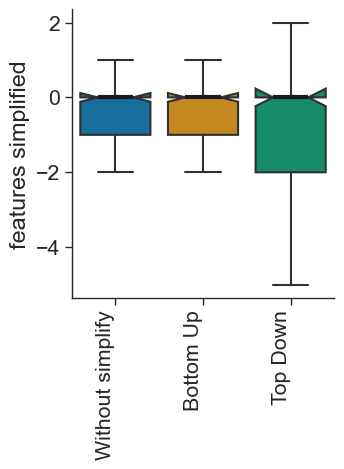

[[<Axes: ylabel='constants simplified'>]]
Without simplify greater TtestResult(statistic=-5.397528453474595, pvalue=0.9999998938418494, df=179)
Without simplify less TtestResult(statistic=-5.397528453474595, pvalue=1.0615815065958563e-07, df=179)
Bottom Up greater TtestResult(statistic=-4.822044562076049, pvalue=0.9999984876058701, df=179)
Bottom Up less TtestResult(statistic=-4.822044562076049, pvalue=1.5123941299102389e-06, df=179)
Top Down greater TtestResult(statistic=-4.874309496994155, pvalue=0.9999988016477518, df=179)
Top Down less TtestResult(statistic=-4.874309496994155, pvalue=1.1983522481702587e-06, df=179)


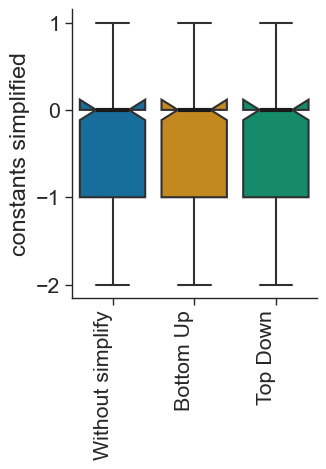

[[<Axes: ylabel='functions simplified'>]]
Without simplify greater TtestResult(statistic=5.828851932621448, pvalue=1.2748491474153028e-08, df=179)
Without simplify less TtestResult(statistic=5.828851932621448, pvalue=0.9999999872515085, df=179)
Bottom Up greater TtestResult(statistic=4.991375528267363, pvalue=7.070354266832923e-07, df=179)
Bottom Up less TtestResult(statistic=4.991375528267363, pvalue=0.9999992929645733, df=179)
Top Down greater TtestResult(statistic=7.030977063809353, pvalue=2.08495902767028e-11, df=179)
Top Down less TtestResult(statistic=7.030977063809353, pvalue=0.9999999999791503, df=179)


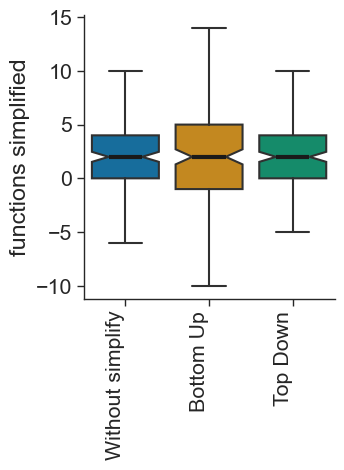

[[<Axes: ylabel='nodes simplified'>]]
Without simplify greater TtestResult(statistic=2.118019127993269, pvalue=0.017776882648182016, df=179)
Without simplify less TtestResult(statistic=2.118019127993269, pvalue=0.982223117351818, df=179)
Bottom Up greater TtestResult(statistic=1.504430156269367, pvalue=0.06711652582952302, df=179)
Bottom Up less TtestResult(statistic=1.504430156269367, pvalue=0.932883474170477, df=179)
Top Down greater TtestResult(statistic=2.0242829179290878, pvalue=0.02221372466418857, df=179)
Top Down less TtestResult(statistic=2.0242829179290878, pvalue=0.9777862753358114, df=179)


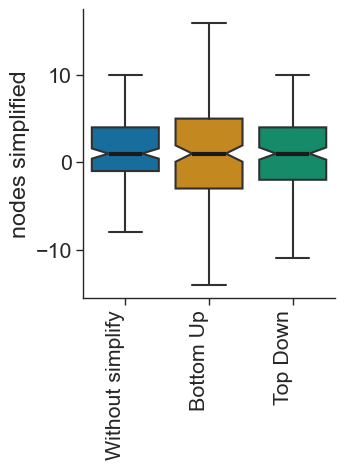

In [4]:
for yaxis in deltas_df.columns:
    g=sns.catplot( data=results_df, y=yaxis, x='model', 
        legend_out=False, aspect=0.75,
        order = order, # The first is Baseline
        **{**boxplot_kwargs, **{'showfliers':False}}, sharey=False
    )

    # g.set(yscale="log")
    g.set_titles("{col_name}").set_axis_labels("", yaxis)

    print(g.axes)

    # iterate through each subplot / Facet>

    for tick in g.axes[0][0].get_xticklabels():
        tick.set(rotation=90, ha="right")

    for model in results_df['model'].unique():
        print(model, 'greater',
              ttest_1samp(
                  (results_df[results_df['model']==model])[yaxis].dropna(),
                  popmean=0.0, alternative='greater'
              )
        )
        print(model, 'less',
              ttest_1samp(
                  (results_df[results_df['model']==model])[yaxis].dropna(),
                  popmean=0.0, alternative='less'
              )
        )

    if False:
        # All vs baseline
        pairs = [('Without simplify', l)
                    for l in results_df['model'].unique()
                    if l != 'Without simplify']

        annotator = Annotator(
            plot_ax, pairs, data=results_df,
            x='model', y=yaxis,
            order=order)
        annotator.reset_configuration()
        annotator.configure(test="Mann-Whitney", hide_non_significant=True, #text_format='full',
                                comparisons_correction="holm", verbose=1, text_offset=-3)
        annotator.apply_and_annotate()

    plt.tight_layout()
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.pdf")
    plt.savefig(f"../paper/figs/{yaxis}_boxplot.png")
    plt.show()